Creating a model to predict how late a flight will be in minutes, based on aviation data from 2008.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn.model_selection import cross_val_score
%matplotlib inline

air = pd.read_csv("2008.csv")

In [2]:
air.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [3]:
air.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

Since we're dealing with a dataset with many continuous and categorical variables, and delays are in a sense both categorical (whether or not they occurred) and continuous (their duration), our choice of models is limited somewhat. Additionally, not many of the variables seem to have a linear relationship with the outcome variable, making multivariate, lasso, and ridge regressions problematic.

I think a model based on decision trees (eg either gradient boosted or random forest) might have decent performance in this situation.

First, some data cleaning.

In [4]:
# Getting rid of year, since this is all 2008 data
air = air.drop('Year',axis=1)

# Get rid of cancelled flights, as these aren't eligible to be late
air = air[air['Cancelled'] == 0]
air = air.loc[pd.isnull(air['CancellationCode']),:]
air = air.drop('CancellationCode',axis=1)

# Not feasible to include airplane type, which has over 5k possible values
air = air.drop('TailNum',axis=1)

# Since we have a lot of data, let's drop one's where time metrics are unavailable (only 15-20k total)
air = air.dropna(subset=['ArrTime','ActualElapsedTime','CRSElapsedTime','AirTime'])

# Converting 'arrdelay' to the 'lateness' that we want to measure
air['lateness'] = air['ArrDelay'] - 30
air['lateness'] = np.where(air['lateness'] < 0, 0, air['lateness'])

# Converting null delays to zero
air[['CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']] = air[['CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].fillna(value=0)

In [5]:
# Creating df with dummies
modeldf = air.drop(['ArrDelay','lateness'],axis=1)
modeldf = pd.get_dummies(modeldf)
modeldf['lateness'] = air['lateness']

In [6]:
# Taking a slice of the df for modeling (given computing restrictions)
sample = modeldf.sample(n=100000)

# Creating model params
X = sample.drop('lateness',axis=1)
Y = sample['lateness']

In [17]:
from sklearn import linear_model
linreg = linear_model.LinearRegression()

cross_val_score(linreg,X,Y,scoring='neg_mean_squared_error')

array([-55.79894035, -53.64192513, -53.77533512])

Seems to do well in cross validation, but let's check how the residuals look.

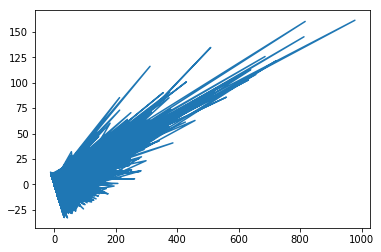

In [26]:
linreg.fit(X,Y)
y_sample_pred = linreg.predict(X)
y_sample_true = Y

residuals = y_sample_true - y_sample_pred

plt.plot(y_sample_pred,residuals)
plt.show()

And predicting on the entire dataset and seeing if the error is consistent.

In [28]:
ytrue = modeldf['lateness']

ypred = linreg.predict(modeldf.drop('lateness',axis=1))

from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(ytrue, ypred)))

7.426258471783282


__Evaluation:__ The model is not very good. We see heteroscedasticity in the predictions, and we're subject to massive outliers. We could do some further feature selection and reduce outliers, but instead it may be better to just rely on a different type of model.

In [34]:
from sklearn import ensemble
rfr = ensemble.RandomForestRegressor()

neg_mean_sqr_error = cross_val_score(rfr,X,Y,scoring='neg_mean_squared_error')
abs_error = np.sqrt(np.abs(neg_mean_sqr_error))
print(abs_error)

Comparing the residual plot and looking at the results on the entire dataset.

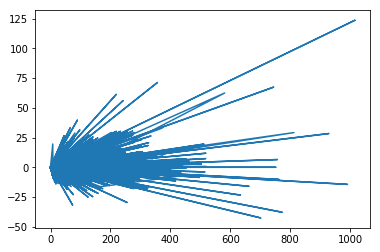

3.4404667171154295


In [32]:
rfr.fit(X,Y)
y_sample_pred = rfr.predict(X)
y_sample_true = Y

residuals = y_sample_true - y_sample_pred

plt.plot(y_sample_pred,residuals)
plt.show()

ytrue = modeldf['lateness']

ypred = rfr.predict(modeldf.drop('lateness',axis=1))

from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(ytrue, ypred)))

In [41]:
rfr.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

This seems to perform much better. Let's do a gridsearch to see if we can improve the model further.

In [44]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10,20,30,40]}

clf = GridSearchCV(rfr, parameters,scoring='neg_mean_squared_error')

clf.fit(X,Y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [45]:
clf.best_params_

{'n_estimators': 30}

In [46]:
ytrue = modeldf['lateness']

ypred = clf.predict(modeldf.drop('lateness',axis=1))

from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(ytrue, ypred)))

3.2200884286417297


Now looking at gradient boosted trees

In [ ]:
from sklearn import ensemble
gbr = ensemble.GradientBoostingRegressor()

neg_mean_sqr_error = cross_val_score(gbr,X,Y,scoring='neg_mean_squared_error')
abs_error = np.sqrt(np.abs(neg_mean_sqr_error))
print(abs_error)

[4.30602416 3.39192337 3.15485788]


Comparing the residual plot and looking at the results on the entire dataset.

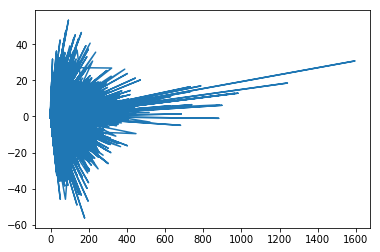

In [ ]:
gbr.fit(X,Y)
y_sample_pred = gbr.predict(X)
y_sample_true = Y

residuals = y_sample_true - y_sample_pred

plt.plot(y_sample_pred,residuals)
plt.show()

ytrue = modeldf['lateness']

ypred = gbr.predict(modeldf.drop('lateness',axis=1))

from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(ytrue, ypred)))

In [ ]:
mean_squared_error(ytrue, ypred)